In [106]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from copy import deepcopy
import cv2
import pandas as pd

In [107]:
class_to_description = {0: "Right Scissors",
                        1: "Left Scissors",
                        2: "Right Needle driver",
                        3: "Left Needle driver",
                        4: "Right Forceps",
                        5: "Left Forceps",
                        6: "Right Empty",
                        7: "Left Empty"}

class_to_color = {0: (31,119,180),#"#1f77b4",
                  1: (255,127,14),#"#ff7f0e",
                  2: (44,160,44),#"#2ca02c",
                  3: (214,39,40),#"#d62728",
                  4: (148,103,189),#"#9467bd",
                  5: (140,86,75),#"#8c564b",
                  6: (227,119,194),#"#e377c2",
                  7: (127,127,127)}#"#7f7f7f"}

# Plotting Some Images

In [108]:
def convert_cv2_to_pil(cv_image):
    img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

In [109]:
def image_grid(cv_images, rows, cols):
    images = [convert_cv2_to_pil(img) for img in cv_images]
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [110]:
images_names = ["P016_balloon1_9",
                "P016_tissue1_536",
                "P017_balloon1_1520",
                "P017_balloon1_662",
                "P016_balloon1_57",
                "P016_balloon1_406", ]

In [111]:
images = [cv2.imread(f'HW1_dataset/images/{img_name}.jpg') for img_name in images_names]

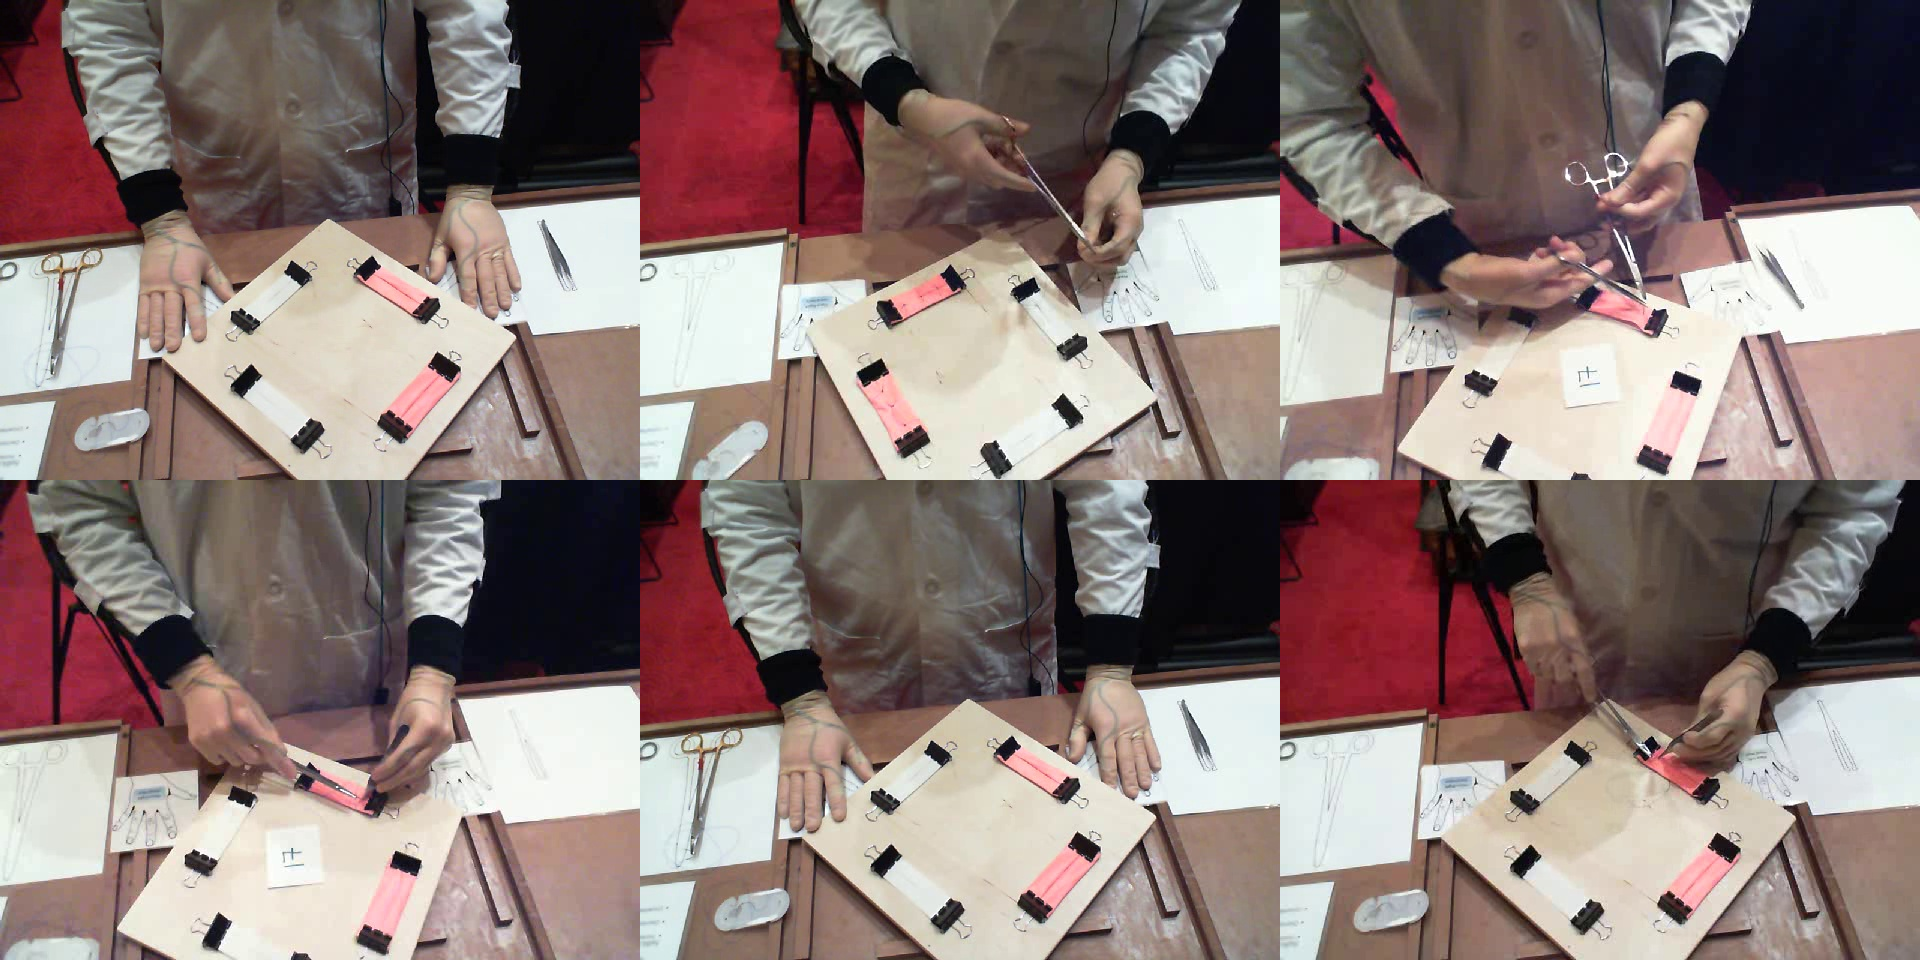

In [112]:
grid = image_grid(images, 2, 3)
grid

### Adding Bounding Boxes

In [113]:
def yolo_to_bbox(img, yolo_format):
    h, w, _ = img.shape
    w_half_len = (yolo_format[3] * w) / 2
    h_half_len = (yolo_format[4] * h) / 2
    xmin = int((yolo_format[1] * w) - w_half_len)
    ymin = int((yolo_format[2] * h) - h_half_len)
    xmax = int((yolo_format[1] * w) + w_half_len)
    ymax = int((yolo_format[2] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


def draw_bboxes(img, classes, bboxes):
    for cls, box in zip(classes, bboxes):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), class_to_color[cls], 2)


def draw_labels(img, classes, bboxes):
    for cls, box in zip(classes, bboxes):
        xmin, ymin, xmax, ymax = box
        label = class_to_description[cls]

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        img = cv2.rectangle(img, (xmin - 1, ymin - 20), (xmin + w, ymin - 1), class_to_color[cls], -1)
        img = cv2.putText(img, label, (xmin, ymin - 5),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)


def create_bbox(img, img_name):
    new_img = deepcopy(img)
    with open(f"HW1_dataset/bboxes_labels/{img_name}.txt", 'r') as f:
        lines = f.readlines()
    lines = [line.strip().split() for line in lines]
    classes = []
    bboxes_yolo = []
    bboxes = []
    for line in lines:
        classes.append(int(line[0]))
        bboxes_yolo.append([classes[-1]])
        for num_str in line[1:]:
            bboxes_yolo[-1].append(float(num_str))
        bboxes.append(yolo_to_bbox(img, bboxes_yolo[-1]))

    draw_bboxes(new_img, classes, bboxes)
    draw_labels(new_img, classes, bboxes)

    return new_img

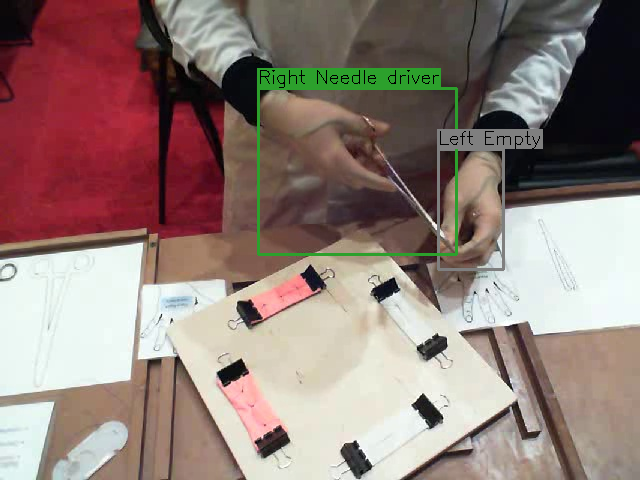

In [114]:
bboxed_img = create_bbox(images[1], images_names[1])
convert_cv2_to_pil(bboxed_img)

In [115]:
bboxed_images = [create_bbox(img, img_name) for img, img_name in zip(images, images_names)]

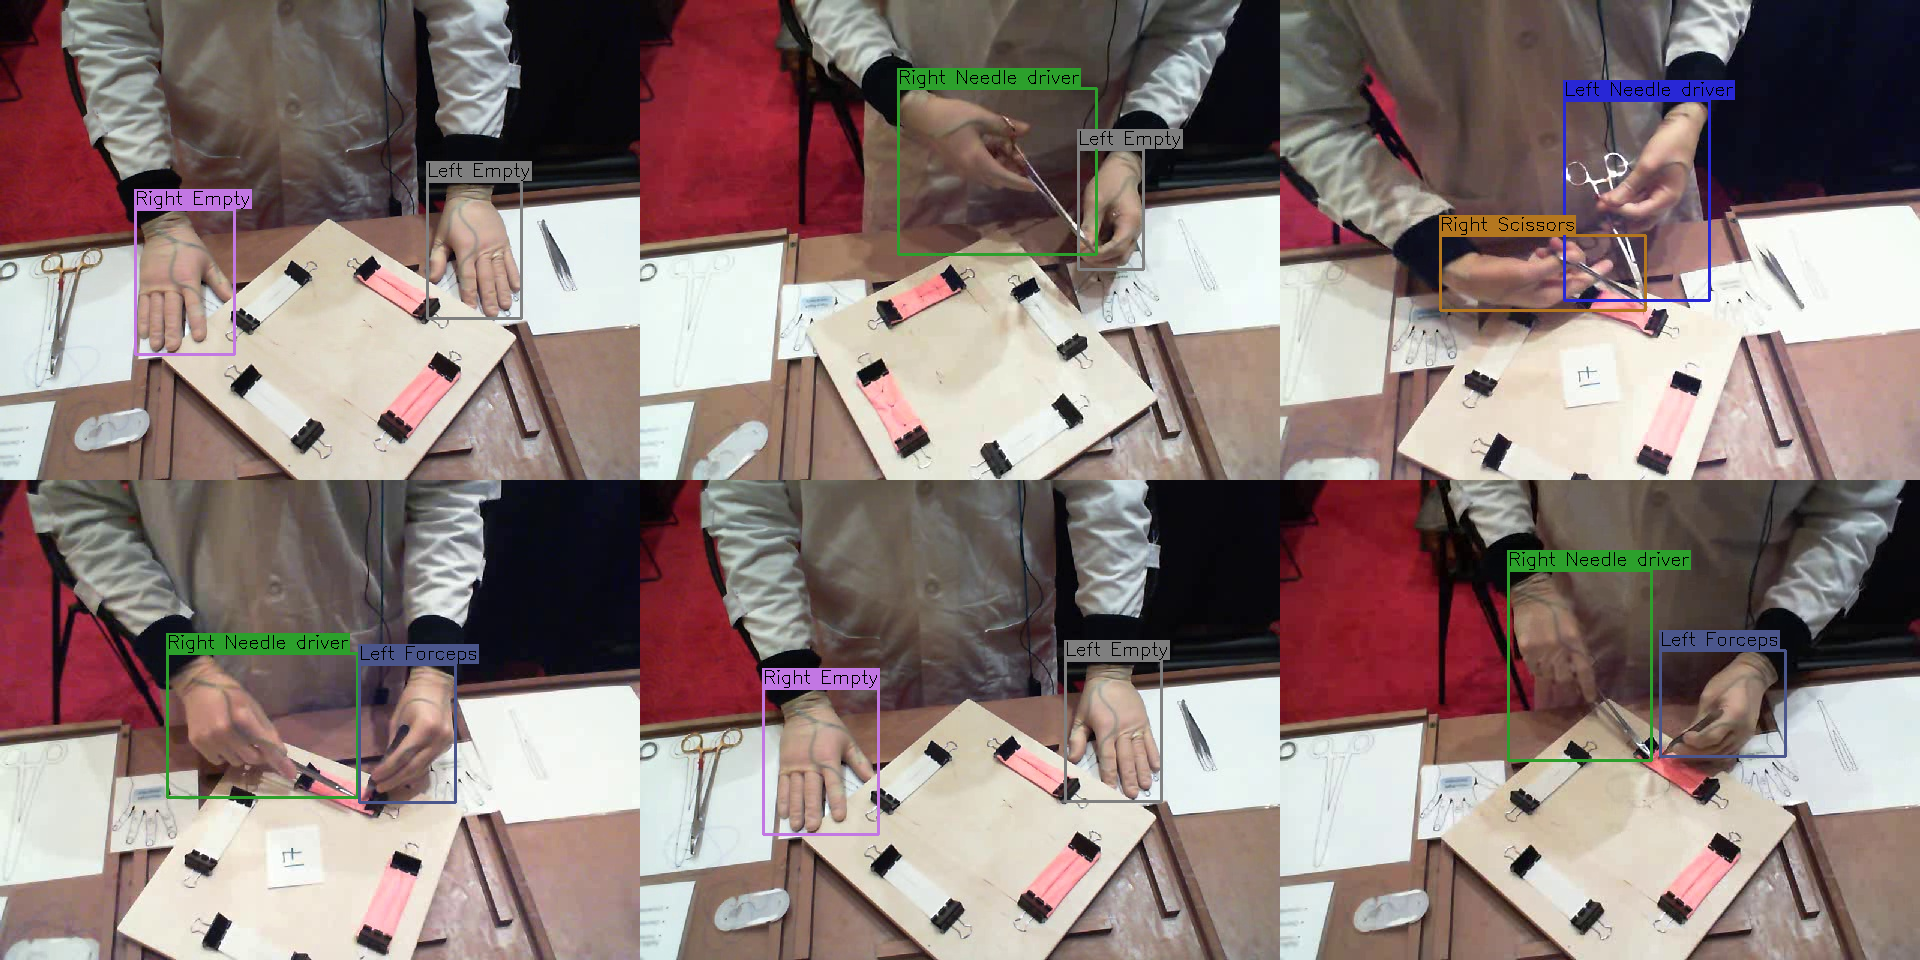

In [116]:
image_grid(bboxed_images, 2, 3)

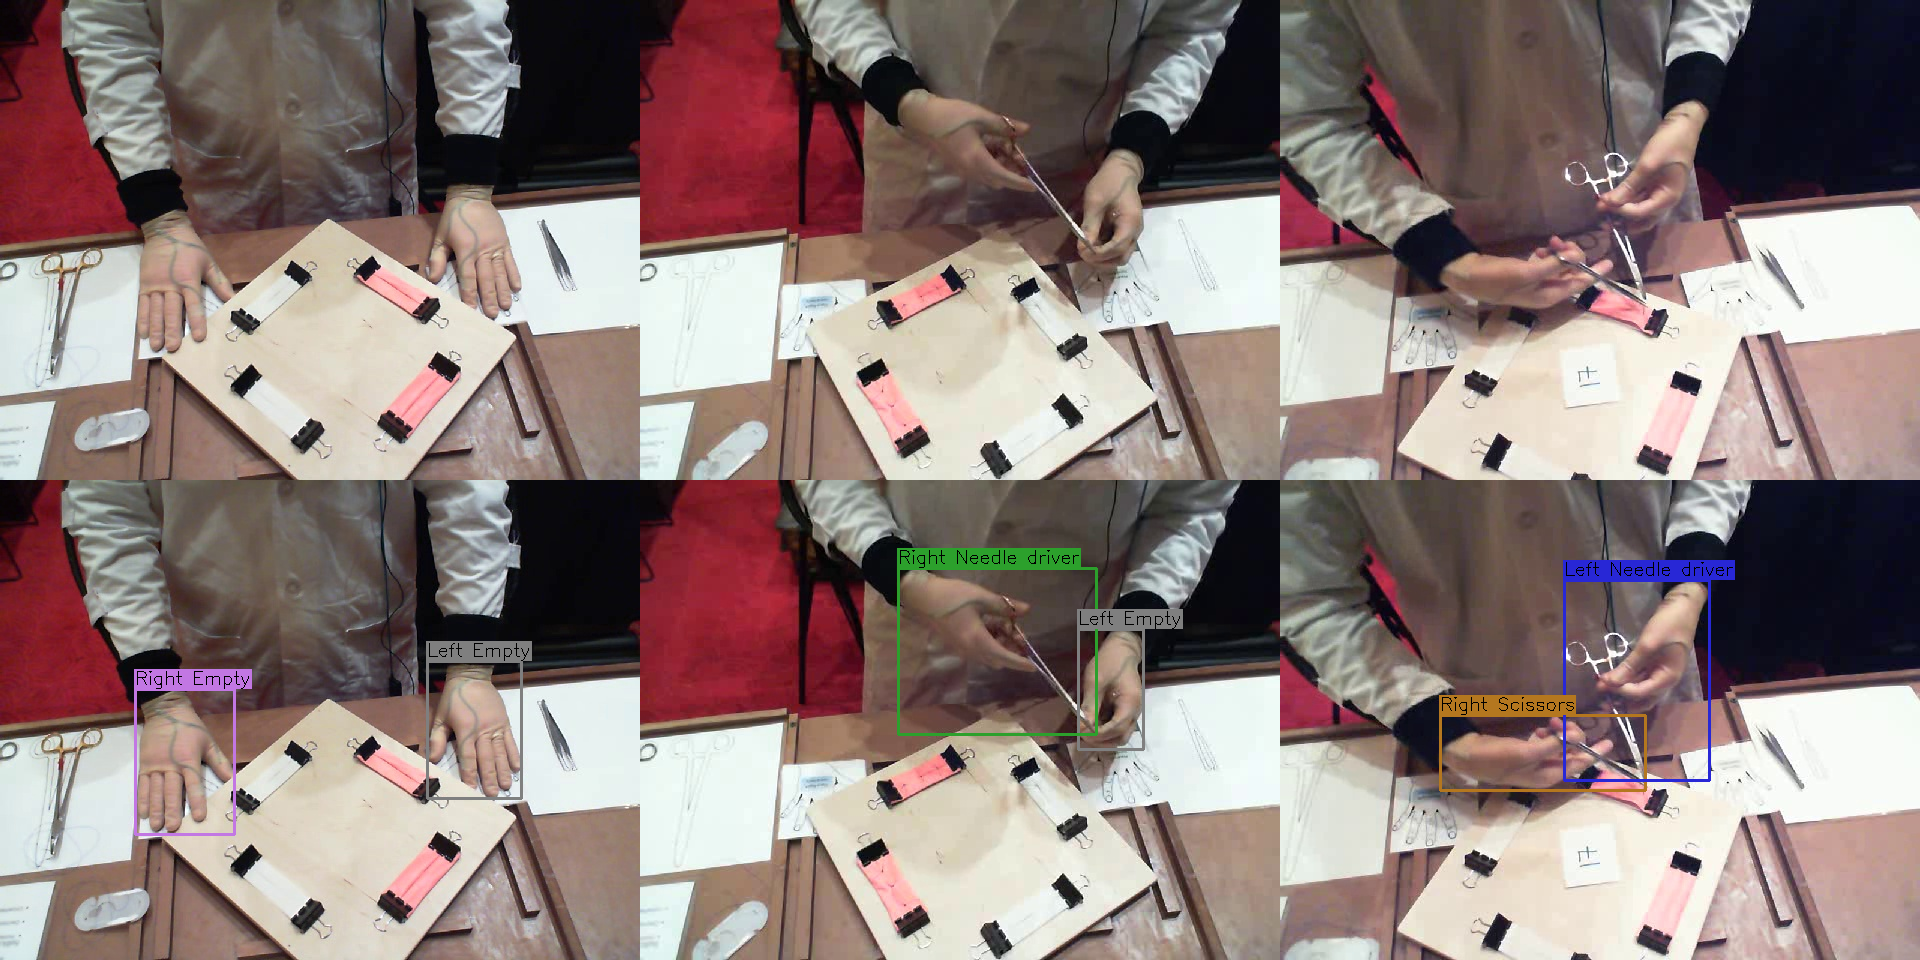

In [117]:
image_grid([*images[:3], *bboxed_images[:3]], 2, 3)

# Exploring Labels

In [118]:
def read_partition_file(path):
    files = []
    with open(path, 'r') as f:
        for untrimmed_line in f:
            line = untrimmed_line.strip()
            files.append(line[:-4])
    return files


def get_classes(path):
    classes = []
    with open(path, 'r') as f:
        for line in f:
            classes.append(int(line.strip().split()[0]))
    return classes

In [119]:
def get_label_distribution(data_type):
    relevant_names = read_partition_file(f"HW1_dataset/{data_type}.txt")
    distribution = {class_to_description[i]: 0 for i in range(len(class_to_description))}
    for name in relevant_names:
        classes = get_classes(f"arranged_dataset/{data_type}/labels/{name}.txt")
        for cls in classes:
            distribution[class_to_description[cls]] += 1
    return distribution


In [120]:
def get_all_label_distributions():
    types = ['train', 'valid', 'test']
    all_distributions = {}
    for data_type in types:
        all_distributions[data_type] = get_label_distribution(data_type)
    return all_distributions

In [121]:
all_label_distributions = get_all_label_distributions()

In [122]:
all_label_distributions

{'train': {'Right Scissors': 186,
  'Left Scissors': 2,
  'Right Needle driver': 532,
  'Left Needle driver': 32,
  'Right Forceps': 0,
  'Left Forceps': 255,
  'Right Empty': 65,
  'Left Empty': 502},
 'valid': {'Right Scissors': 29,
  'Left Scissors': 0,
  'Right Needle driver': 95,
  'Left Needle driver': 6,
  'Right Forceps': 0,
  'Left Forceps': 44,
  'Right Empty': 7,
  'Left Empty': 82},
 'test': {'Right Scissors': 42,
  'Left Scissors': 1,
  'Right Needle driver': 137,
  'Left Needle driver': 10,
  'Right Forceps': 0,
  'Left Forceps': 62,
  'Right Empty': 20,
  'Left Empty': 126}}

In [123]:
distribution = {label: [all_label_distributions[data_type][class_to_description[cls]] for data_type in
                        all_label_distributions.keys()] for cls, label in
                class_to_description.items()}
df = pd.DataFrame(distribution)
df = df.reset_index().rename(columns={'index': 'Type'})
df['Type'] = ("train", "valid", "test")
df

Type  Right Scissors  Left Scissors  Right Needle driver  \
0  train             186              2                  532   
1  valid              29              0                   95   
2   test              42              1                  137   

   Left Needle driver  Right Forceps  Left Forceps  Right Empty  Left Empty  
0                  32              0           255           65         502  
1                   6              0            44            7          82  
2                  10              0            62           20         126

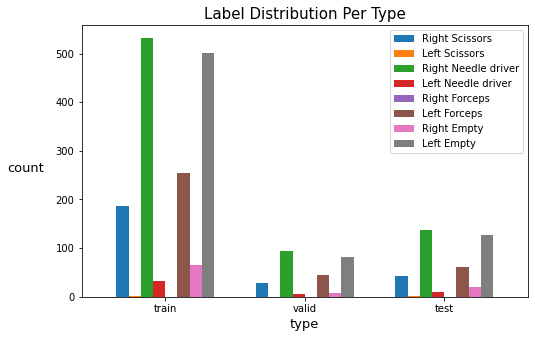

In [125]:
df.plot(x='Type',
        kind='bar',
        stacked=False,
        rot=0,
        width=0.7,
        figsize=(8, 5)
        )

# plt.xticks([0, 0.5, 1], ['train', 'valid', 'test'])
plt.xlabel('type', size=13)
plt.ylabel('count', size=13, rotation=0, labelpad=30, y=0.45)
plt.title('Label Distribution Per Type', size=15)
plt.show()

In [126]:
def plot_pie_distributions(all_label_distributions):
    train = all_label_distributions['train']
    valid = all_label_distributions['valid']
    test = all_label_distributions['test']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

    ax1.pie(train.values(), autopct='%.1f%%')
    ax1.set_title('Train', size=15)
    ax2.pie(valid.values(), autopct='%.1f%%')
    ax2.set_title('Valid', size=15)
    ax3.pie(test.values(), autopct='%.1f%%')
    ax3.set_title('Test', size=15)

    fig.legend(labels=class_to_description.values(), bbox_to_anchor=(1, 0.75))
    plt.show()

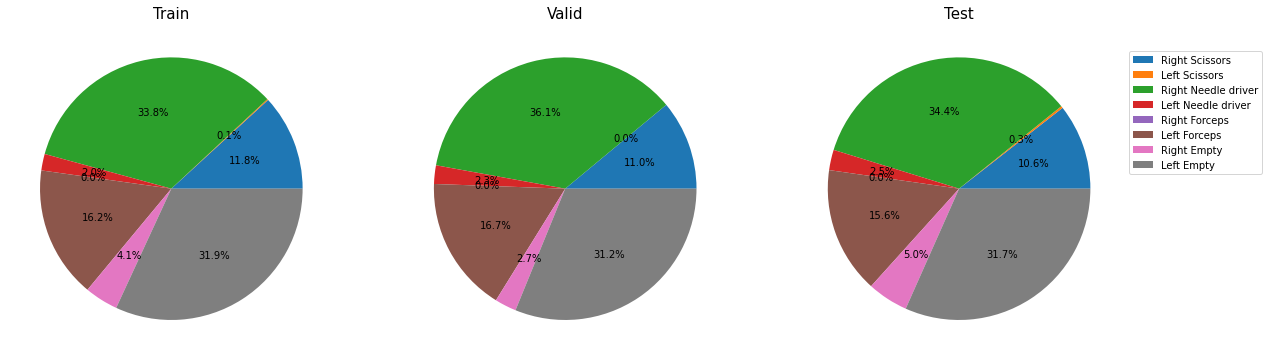

In [127]:
plot_pie_distributions(all_label_distributions)